# Double/Debiased Machine Learning

- Paper: [Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). Double/debiased machine learning for treatment and structural parameters.](https://academic.oup.com/ectj/article/21/1/C1/5056401?login=false)
- Python Package: [DoubleML](https://docs.doubleml.org/stable/index.html)

## 概要

世の中の多くの現象は非線形な関係性が想定される。回帰分析は線形モデルであるため、モデルの定式化の誤りに起因するバイアスが生じかねない。

実際に関心のあるパラメータは少なく、交絡のコントロールのために入れている局外母数（nuisance parameters）は高次元になりがち。

局外母数を非線形の関数$g_0(X)$で表し、関心のあるパラメータ$\theta_0$は線形モデルで表現する **部分線形モデル**（partially linear regression: PLR）

$$
Y = D\theta_0 + g_0(X) + U, \hspace{1em} E[U|X,D] = 0\\
D = m_0(X) + V, \hspace{1em} E[V|X] = 0
$$

を作り、局外関数$g_0(X)$を機械学習で構築したい。

もしこれが実現できれば、非線形部分を機械学習による優れた関数近似性能で捉えて交絡をコントロールしつつ、パラメータは線形回帰モデルのように推定できる。

これを実現するのがDMLのフレームワークである（$g_0$は任意の機械学習アルゴリズムでよいので、DMLは具体的なアルゴリズムに踏み込まず、フレームワーク）。


## 先行研究

[Robinson (1988)](https://www.jstor.org/stable/1912705) は部分線形モデルを提案し、一致推定量も導出した


:::{admonition} Robinson (1988)の推定量

部分線形モデル

$$
Y = D \theta_0 + g_0(X) + U, \quad E[U|X, D]=0
$$

の両辺を$X$で条件づけて期待値をとると

$$
E[Y|X] = E[D|X] \theta_0 + g_0(X)
$$

これをモデルから差し引くと

$$
Y - E[Y|X] = \theta_0 (D - E[D|X]) + U
$$

という線形回帰の形になる（FWL定理の残差回帰の形）

$\tilde{Y}_i = Y_i - E[Y_i|X_i]$、$\tilde{D}_i = D_i - E[D_i|X_i]$とおけば、OLS推定量の形になる

$$
\hat{\beta}_{\mathrm{inf}}=\left(\sum_{i=1}^n \tilde{D}_i \tilde{D}_i^T \right)^{-1} \sum_{i=1}^n \tilde{D}_i \tilde{Y}_i
$$


ただし、$E[Y|X], E[D|X]$は未知なのでそれぞれノンパラメトリック推定量$\hat{\ell}(X), \hat{m}(X)$で置き換える（このようにノンパラ推定量で置換する推定量はプラグイン推定量という）。

その推定量はroot-N consistentで漸近正規性を持つ

**参考**

- [末石直也 - セミ・ノンパラメトリック計量分析 (京都大学)](https://sites.google.com/site/naoyasueishij/teaching/nonpara) 第5回 [部分線形モデルとセミパラメトリック推定量の性質](https://drive.google.com/file/d/0B6W_J4QoAI6wcWdwYkNwUU5DWTA/view?resourcekey=0--WtAUb3PgzgBpsw1XtvhzQ)
- 西山・人見（2023）『ノン・セミパラメトリック統計解析』、共立出版
- [Robinson, P. M. (1988). Root‐N‐consistent semi‐parametric regression. Econometrica 56, 931–54.](https://www.jstor.org/stable/1912705)
:::






### Donsker条件

[Andrew (1994)](https://www.jstor.org/stable/2951475) はプラグイン推定量が漸近正規性・$\sqrt{n}$-consistent 一致性をもつ条件を明らかにした

その条件を満たすために使われるのが、Donsker条件（Donsker condition）という条件を満たすクラスの関数（複雑性の低い関数）をノンパラメトリック推定量に使うというもの。

機械学習アルゴリズムによる推定量は複雑度が高く、一般にDonsker条件を満たさない。**よってRobinson（1988）の推定量に機械学習をそのまま組み込むと漸近正規推定量・$\sqrt{n}$-consistentにならない**


## 課題

$g_0(X)$を機械学習で作って線形回帰するだけだと推定量は$\sqrt{n}$の収束レートにならない

2つのバイアスがある

1. 正則化バイアス（Reguralization bias）
2. 過学習によるバイアス（Bias induced by overfifting）

それぞれの対策として、

1. 正則化バイアス → **ネイマン直交化（例：残差回帰）** で対応
2. 過学習 → **Cross-Fitting** で対応

を行う

## 前提知識

知ってると理解を深めやすくなる前提知識まとめ



::::{dropdown} （参考）残差回帰

DMLでは、FWL定理を利用した残差回帰を一般化する。

残差回帰は線形回帰モデル

$$
Y = X_1 \beta_1 + X_2 \beta_2 + e
$$

を用いて

$$
Y - X_2 \hat{\gamma} = (X_1 - X_2 \hat{\delta}) \beta_1
$$

のようにして関心のあるパラメータ$\beta_1$を推定する。

線形回帰モデルは回帰関数$E[Y|X]$を近似するため、上記の残差回帰は期待値を用いて

$$
Y - E[Y|X_2] = (X_1 - E[X_1|X_2]) \beta_1
$$

と表すことができる。


:::{admonition} FWL定理

目的変数のベクトル$Y \in \mathbb{R}^{n\times 1}$、説明変数の行列$X \in \mathbb{R}^{n\times d}$と誤差項$e \in \mathbb{R}^{n\times 1}$による線形回帰モデル

$$
Y = X \beta + e
$$

があるとする。

説明変数を$X = (X_1 | X_2)$と2つのグループに分割し、回帰係数ベクトル$\beta$も合わせて$\beta = (\beta_1 | \beta_2)^T$と2つに分割して

$$
Y = X_1 \beta_1 + X_2 \beta_2 + e
$$


と表す。

この回帰モデルの$\beta_1$は、**残差回帰**（residual regression）と呼ばれる以下の手順に従うことでも得ることができる。

1. $X_1$を$X_2$に回帰して残差$\tilde{X}_1$を得る：$\tilde{X}_1 = X_1 - X_2 \hat{\delta}$
2. $Y$を$X_2$に回帰して残差$\tilde{Y}$を得る：$\tilde{Y} = Y - X_2 \hat{\gamma}$
3. $\tilde{Y}$を$\tilde{X}_1$に回帰させる：$\tilde{Y} = \tilde{X}_1 \beta_1$
:::
::::

::::{dropdown} （参考）モーメント法

確率変数$X$が$\theta$というパラメータをもつ分布に従うとする。

$$
E[\psi(X; \theta)] = 0
$$

という条件（直交条件）を満たすスコア関数$\psi(X; \theta)$があるとき、標本$X_1, \dots, X_n$を使った直交条件

$$
\frac{1}{n} \sum^n_{i=1} \psi(X_i; \theta) = 0
$$

を解いて$\theta$を推定する方法を **モーメント法** （method of moments） という。

:::{admonition} 例：線形回帰モデル

線形回帰モデル

$$
Y_i = X_i^T \beta + u_i
$$

のパラメータ$\beta$の推定を考える。ここで$X$と$\beta$は$(k \times 1)$ベクトルとする。$X$は誤差項と無相関$E[X_i u_i] = 0$であるとする。

このモデルから$k$本のモーメント条件が得られる

$$
E[X_i u_i] = E[X_i (Y_i - X_i^T \beta)] = 0
$$

標本対応は

$$
\frac{1}{n} \sum^n_{i=1} X_i u_i
= \frac{1}{n} \sum^n_{i=1} X_i (Y_i - X_i^T \beta)
$$

行列表記では

$$
\frac{1}{n} X^T u
= \frac{1}{n} X^T (Y - X\beta) = 0
$$

となる。これを解くと

$$
\frac{1}{n} X^T Y = \frac{1}{n} X^T X\beta\\
\to \beta = (X^T X)^{-1}X^T Y
$$

と、最小二乗法の解と一致する
:::

::::

:::{dropdown} （参考）漸近理論

確率変数列$X_n$の分布関数がある確率変数$X$の分布関数に収束するとき

$$
\mathrm{P}\left(X_n \leq x\right) \rightarrow \mathrm{P}(X \leq x)
$$

**分布収束** （converge in distribution）や **法則収束**（convergence in law） や **弱収束** （weak convergence） と呼び、

$$
X_n \overset{d}{\to} X,\quad
X_n \rightsquigarrow X
$$

などと表す。$X$がある分布$L$に従う場合は

$$
X_n \overset{d}{\to} L,\quad
X_n \rightsquigarrow L
$$

などと表す。
:::

## ナイーブな推定量と正則化バイアス

### サンプル分割

のちのCross Fittingでサンプル分割の話になるので、数式の記法もあらかじめ分割に対応させておく。

main sampleは$n$個のサンプルからなり、$i\in I$のインデックスで表す。補助サンプルは$N-n$として$i \in I^c$とする。単純のため2つに分割するだけにし、$n=N/2$とする。

補助パートのサンプルで$\hat{g}_0$を獲得し、$\theta_0$の推定にメインパートのサンプルを使うことにする。

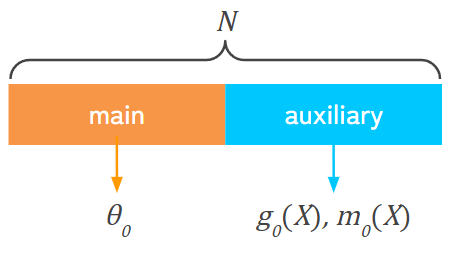

### ナイーブな推定量

線形回帰モデル$Y = X\beta + U$のモーメント条件は

$$
E[U X] = E[(Y - X^T \beta) X] = 0
$$

であった。これと同様に部分線形モデルにおいて

$$
E[UD] = E[(Y - \theta D - g(X))D] = 0
$$

というモーメント条件を考えると、その推定量は

$$
\hat{\theta}_0 = \left( \frac{1}{n} \sum_{i\in I} D_i^2 \right)^{-1}
\frac{1}{n} \sum_{i\in I} D_i (Y_i - \hat{g}_0(X_i))
$$

となる。この推定量$\hat{\theta}_0$は一般に$1/\sqrt{n}$より遅い収束レート、つまり

$$
|\sqrt{n} (\hat{\theta}_0 - \theta_0)| \overset{p}{\to} \infty
$$

となる。

この「劣った」振る舞いの背後には$g_0$の学習におけるバイアスがある。

ヒューリスティックにこの$\hat{g}_0$の学習のバイアスのインパクトを説明すると、スケールされた$\hat{\theta}_0$の推定誤差は

$$
\sqrt{n} (\hat{\theta}_0 - \theta_0) =
\underbrace{
    \left( \frac{1}{n} \sum_{i\in I} D_i^2 \right)^{-1}
    \frac{1}{\sqrt{n}} \sum_{i\in I} D_i U_i
}_{:=a}
+
\underbrace{
    \left( \frac{1}{n} \sum_{i\in I} D_i^2 \right)^{-1}
    \frac{1}{\sqrt{n}} \sum_{i\in I} D_i (g_0(X_i) - \hat{g}_0(X_i))
}_{:=b}
$$

である。

第1項$a$は$a \rightsquigarrow N(0, \bar{\Sigma})$となるので問題ない。第2項の$b$の項は正則化バイアス項で、一般に中心にならず発散する。first orderで以下を得る

$$
b = (E[D_i^2])^{-1}
\frac{1}{\sqrt{n}} \sum_{i\in I}
m_0(X_i)(g_0(X_i) - \hat{g}_0(X_i)) + o_P(1)
$$

ヒューリスティックには、$b$は平均がゼロにならない$m_0(X_i)(g_0(X_i) - \hat{g}_0(X_i))$の$n$個の総和で、$\sqrt{n}$で割られる。これらの項は非ゼロの平均になる。なぜなら一般に機械学習手法は正則化推定量を採用するためである。正則化は推定量の分散が爆発しないようにするものの相当なバイアスを引き起こす。とりわけ、$g_0$への$\hat{g}_0$のバイアスの収束レートは、RMSEにおいて$n^{-\phi_g}$（$\phi_g < 1/2$）である。ゆえに$b$は$D_i$が$m_0(X_i)\neq 0$で中心化されるとき$\sqrt{n} n^{-\phi_g} \to \infty$の確率的オーダーになることが期待され、よって$|\sqrt{n} (\hat{\theta}_0 - \theta_0)| \overset{p}{\to} \infty$となる

[1. The basics of double/debiased machine learning — DoubleML documentation](https://docs.doubleml.org/stable/guide/basics.html)

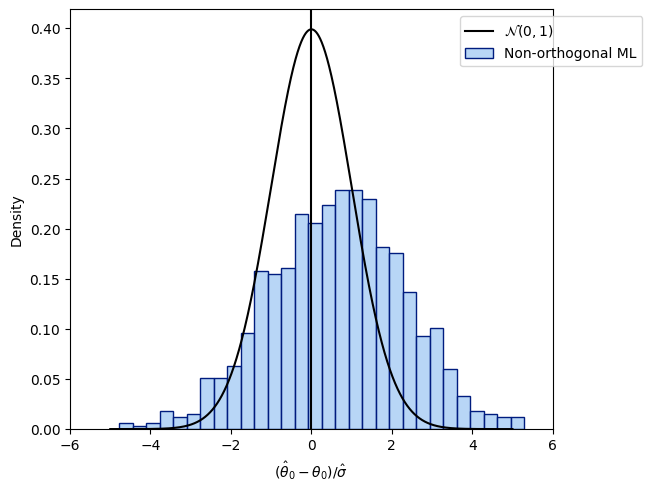

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from doubleml.datasets import make_plr_CCDDHNR2018
np.random.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 20
alpha = 0.5
data = list()
for i_rep in range(n_rep):
    (x, y, d) = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    data.append((x, y, d))

def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')
np.random.seed(1111)
ml_l = RandomForestRegressor(n_estimators=132, max_features=12, max_depth=5, min_samples_leaf=1)
ml_m = RandomForestRegressor(n_estimators=378, max_features=20, max_depth=3, min_samples_leaf=6)
ml_g = clone(ml_l)

# シミュレーションに時間がかかるので結果を保存する
import json
from pathlib import Path
result_json_path = Path('./dml_simulation_results.json')
use_cache = True

# 実験1: ネイマン直交条件を満たさない場合
if use_cache and result_json_path.exists():
    with open(result_json_path, "r") as f:
        simulation_results = json.load(f)
        simulation_results = {k: np.array(v) for k,v in simulation_results.items()}
    theta_nonorth = simulation_results["theta_nonorth"]
    se_nonorth = simulation_results["se_nonorth"]
else:
    theta_nonorth = np.zeros(n_rep)
    se_nonorth = np.zeros(n_rep)
    for i_rep in range(n_rep):
        (x, y, d) = data[i_rep]
        obj_dml_data = DoubleMLData.from_arrays(x, y, d)
        obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                          ml_l, ml_m, ml_g,
                                          n_folds=2,
                                          apply_cross_fitting=False,
                                          score=non_orth_score)
        obj_dml_plr_nonorth.fit()
        this_theta = obj_dml_plr_nonorth.coef[0]
        this_se = obj_dml_plr_nonorth.se[0]
        theta_nonorth[i_rep] = this_theta
        se_nonorth[i_rep] = this_se

    simulation_results = {}
    simulation_results["theta_nonorth"] = theta_nonorth
    simulation_results["se_nonorth"] = se_nonorth
# plot
plt.figure(constrained_layout=True)
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                  color=face_colors[0], edgecolor=edge_colors[0],
                  stat='density', bins=30, label='Non-orthogonal ML')
ax.axvline(0., color='k')
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.set_xlim([-6., 6.])
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
plt.show()

## 直交化による正則化バイアスの打破

DからXの効果をpartialling outして直交化された

$$
\hat{V} = D - \hat{m}_0(X)
$$

を使用する方法を考える。ここで$\hat{m}_0$は補助的サンプル（auxiliary sample）を用いたML推定量である。

DからXの効果をpartialling out したあとは、main sampleを使って$\theta_0$のdebiased ML (DML)を構築する

$$
\check{\theta}_0 = \left( \frac{1}{n} \sum_{i\in I} \hat{V}_i D_i \right)^{-1}
\frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{g}_0(X_i))
$$

近似的にDをXについて直交化し、$g_0$の推定値を引くことで近似的に交絡の直接効果を除去することで、$\check{\theta}_0$は(1.3)の正則化バイアスを除去している。



:::{card} IV推定量と似てる

DML:

$$
\check{\theta}_0 = \left( \frac{1}{n} \sum_{i\in I} \hat{V}_i D_i \right)^{-1}
\frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{g}_0(X_i))
$$

IV:

$$
\hat{\theta}_0^{IV} = \left( \frac{1}{n} \sum_{i=1}^n Z_i X_i^T \right)^{-1}
\frac{1}{n} \sum_{i=1}^n Z_i Y_i
$$


:::


:::{card}
$\hat{V}$も入れて書くと

$$
\check{\theta}_0 = \left( \frac{1}{n} \sum_{i\in I} \left(D_i - \hat{m}_0(X_i)\right) D_i \right)^{-1}
\frac{1}{n} \sum_{i\in I} \left(D_i - \hat{m}_0(X_i)\right) \left(Y_i - \hat{g}_0(X_i) \right)
$$
:::


Text(0.5, 0, '$(\\hat{\\theta}_0 - \\theta_0)/\\hat{\\sigma}$')

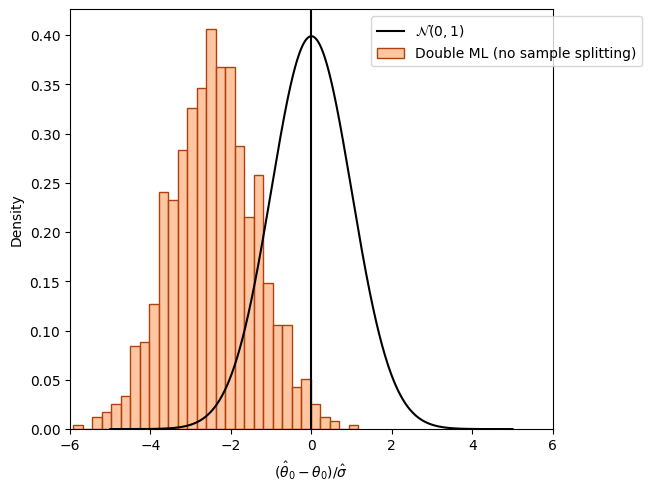

In [2]:
# 実験2: 直交化した場合
if use_cache and result_json_path.exists():
    with open(result_json_path, "r") as f:
        simulation_results = json.load(f)
        simulation_results = {k: np.array(v) for k,v in simulation_results.items()}
    theta_orth_nosplit = simulation_results["theta_orth_nosplit"]
    se_orth_nosplit = simulation_results["se_orth_nosplit"]
else:
    theta_orth_nosplit = np.zeros(n_rep)
    se_orth_nosplit = np.zeros(n_rep)

    for i_rep in range(n_rep):
        (x, y, d) = data[i_rep]
        obj_dml_data = DoubleMLData.from_arrays(x, y, d)
        obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                               ml_l, ml_m, ml_g,
                                               n_folds=1,
                                               score='partialling out',
                                               apply_cross_fitting=False)
        obj_dml_plr_orth_nosplit.fit()
        this_theta = obj_dml_plr_orth_nosplit.coef[0]
        this_se = obj_dml_plr_orth_nosplit.se[0]
        theta_orth_nosplit[i_rep] = this_theta
        se_orth_nosplit[i_rep] = this_se

    simulation_results["theta_orth_nosplit"] = theta_orth_nosplit
    simulation_results["se_orth_nosplit"] = se_orth_nosplit

# plot
plt.figure(constrained_layout=True)
ax = sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
                  color=face_colors[1], edgecolor=edge_colors[1],
                  stat='density', bins=30, label='Double ML (no sample splitting)')
ax.axvline(0., color='k')
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.set_xlim([-6., 6.])
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')

### Neyman Orthogonality

partialling outしたモーメント条件による推定量とナイーブな推定量は何が違うのか？

→ ネイマン直交性（Neyman orthogonality）がカギになる。

:::{admonition} ネイマン直交性

サンプル$W$、関心のあるパラメータ$\theta_0$、局外母数$\eta_0$についてのスコア関数$\psi(W; \theta_0, \eta_0)$のベクトル$\psi = (\psi_1, \dots, \psi_d)^T$があるとする。このスコア関数の直交条件

$$
E[\psi(W; \theta_0, \eta_0)] = 0
$$

について、ガトー微分が存在し、微小な$\eta$の推定誤差についての微分が0となる

このことを **ネイマン直交性（Neyman orthogonality）** という
:::

意訳：真の局外母数η0=(m0, g0)と任意のηとの微小な差による直交条件の変化が0であること

→ ηの推定誤差に対して頑健（robust）であること

→ ネイマン直交性をもつスコア関数を用いる推定量は正則化バイアスに対し頑健になる


### $\check{\theta}_0$の性質

スケールされた推定誤差は３つの要素に分解できる

$$
\sqrt{n}(\check{\theta}_0 - \theta_0)
= a^* + b^* + c^*
$$

$a^*$はmild conditionsのもとで以下を満たす

$$
a^* = (E[V^2])^{-1}
\frac{1}{\sqrt{n}} \sum_{i\in I} V_i U_i \rightsquigarrow N(0, \Sigma)
$$

$b^*$は$g_0, m_0$の推定における正則化バイアスの影響を捉える。具体的には

$$
b^* = (E[V^2])^{-1}
\frac{1}{\sqrt{n}} \sum_{i\in I} 
(\hat{m}_0(X_i) - m_0(X_i))
(\hat{g}_0(X_i) - g_0(X_i))
$$

で、これは$\hat{m}_0$と$\hat{g}_0$の推定誤差の積に依存する。そのため、幅広い範囲のデータ生成過程のもとで消失させることが可能である。

実際、この項は$\sqrt{n}n^{-(\phi_m+\phi_g)}$で上界になり、ここで$n^{-\phi_m}, n^{-\phi_g}$はそれぞれ$\hat{m}_0, \hat{g}_0$の$m_0, g_0$への収束レートである。これは両者が比較的遅い収束レートで推定されたとしても、消失しうる。


（多くのMLアルゴリズムが$n^{-1/4}$程度の収束レートらしいので、$g,m$の推定誤差の積が$n^{-1/4} \times n^{-1/4} = n^{-1/2}$みたいなイメージなんじゃないか、という話がある （[参考](https://speakerdeck.com/masa_asa/debiased-ml?slide=11)))


$c^*$は

$$
c^* = o_P(1)
$$

となる。これが弱い条件のもとで成り立つことを保証するにあたって、sample splittingが重要な役割を果たす。

## Cross Fittingによる過学習のバイアスの除去

DML推定量の$\sqrt{n}$でスケールした推定誤差

$$
\sqrt{n}(\check{\theta}_0 - \theta_0)
= a^* + b^* + c^*
$$

のうち、$c^*$が確率的に消失するためにsample splittingが使われる。

$c^*$は

$$
\frac{1}{\sqrt{n}} \sum_{i \in I} V_i (\hat{g}_0(X_i) - g_0(X_i))
$$

などの項を含む。
この項は局外関数の推定誤差と部分線形モデルの構造的未観測要因の積の和を$1/\sqrt{n}$-normalizedしたものである。

sample splittingを使うと、このような項をシンプルでタイトにコントロールできる。それを確認するため、観測値が独立と仮定して、$\hat{g}_0$が補助的サンプルの観測値のみで推定されることを思い出そう。

$E[V_i|X_i]=0$であることを思い出すと、この項は平均ゼロで分散は

$$
\frac{1}{n} \sum_{i \in I} (\hat{g}_0(X_i) - g_0(X_i))^2
\overset{p}{\to}
0
$$

であることがわかり、チェビシェフの不等式を使って確率的には消失することがわかる。


:::{dropdown} なぜ平均ゼロになるのか

条件付き期待値の性質$E[X]=E_Y[E(X|Y)]$により

$$
\begin{aligned}
E[V_i (\hat{g}_0(X_i) - g_0(X_i))]
&= E_X[E[V_i (\hat{g}_0(X_i) - g_0(X_i)) \mid X ] ]\\
&= E_X[ (\hat{g}_0(X_i) - g_0(X_i)) \underbrace{ E[V_i \mid X ] }_{=0} ]\\
&= E[0] = 0
\end{aligned}
$$

ということかと思われる
:::


sample splittingの欠点は推定に使用するサンプル数が減ることによる効率性の低下である。しかし、mainとauxiliaryの2つでそれぞれ推定を行い、両者の平均を取ればfull efficiencyを取り戻す。この手続き（mainとauxiliaryの役割を取り替えて複数の推定値を取得しそれらの平均をとる）を「**cross-fitting**」と呼ぶことにする。一般にk-foldにすることもできる。

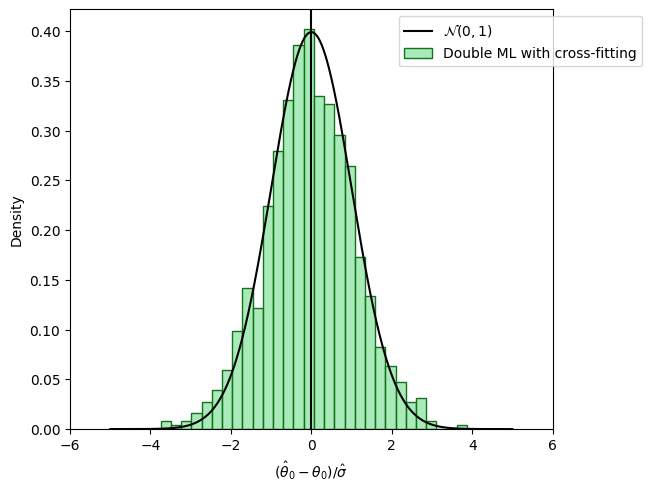

In [3]:
# 実験2: 直交化した場合
if use_cache and result_json_path.exists():
    with open(result_json_path, "r") as f:
        simulation_results = json.load(f)
        simulation_results = {k: np.array(v) for k,v in simulation_results.items()}
    theta_dml = simulation_results["theta_dml"]
    se_dml = simulation_results["se_dml"]
else:
    theta_dml = np.zeros(n_rep)
    se_dml = np.zeros(n_rep)

    for i_rep in range(n_rep):
        (x, y, d) = data[i_rep]
        obj_dml_data = DoubleMLData.from_arrays(x, y, d)
        obj_dml_plr = DoubleMLPLR(obj_dml_data,
                                  ml_l, ml_m, ml_g,
                                  n_folds=2,
                                  score='partialling out')
        obj_dml_plr.fit()
        this_theta = obj_dml_plr.coef[0]
        this_se = obj_dml_plr.se[0]
        theta_dml[i_rep] = this_theta
        se_dml[i_rep] = this_se

    simulation_results["theta_dml"] = theta_dml
    simulation_results["se_dml"] = se_dml
    simulation_results = {k:list(v) for k,v in simulation_results.items()}
    with open(result_json_path, "w") as f:
        json.dump(simulation_results, f)

# plot
plt.figure(constrained_layout=True)
ax = sns.histplot((theta_dml - alpha)/se_dml,
                  color=face_colors[2], edgecolor = edge_colors[2],
                  stat='density', bins=30, label='Double ML with cross-fitting')
ax.axvline(0., color='k')
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.set_xlim([-6., 6.])
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
plt.show()

### Cross Fitting

:::{admonition} Definition 3.1.DML1

(1) サンプル$(W_i)^N_{i=1}$のインデックス$[N]=\{1,\dots,N\}$のK-foldのランダムな分割$\left(I_k\right)_{k=1}^K$ を作る。

$I_k$のサイズは$n=N/K$である。

それぞれの$k\in[K]=\{1,\dots,K\}$について、$I_k^c := \{1,\dots,N\} \backslash I_k$を定義する。

(2) 各$k\in[K]$について、局外母数$\eta_0$のML推定量

$$
\hat{\eta}_{0, k}=\hat{\eta}_0\left(\left(W_i\right)_{i \in I_k^c}\right)
$$

を構築する。

(3) 各$k\in[K]$について、推定量$\check{\theta}_{0, k}$を

$$
\mathbb{E}_{n, k}\left[
\psi \left(W ; \check{\theta}_{0, k}, \hat{\eta}_{0, k} \right)
\right]=0
$$

の解として構築する。$\psi$はネイマン直交スコアで、$\mathbb{E}_{n, k}$は経験期待値

$$
\mathbb{E}_{n, k}[\psi(W)] = \frac{1}{n} \sum_{i \in I_k} \psi\left(W_i\right)
$$

である。

なお、もし厳密に0にするのが不可能である場合は、推定量$\check\theta_{0,k}$は近似解

$$
\left\|E_{n, k}\left[\psi\left(W ; \check{\theta}_{0, k}, \hat{\eta}_{0, k}\right)\right]\right\| \leq \inf _{\theta \in \Theta}\left\|E_{n, k}\left[\psi\left(W ; \theta, \hat{\eta}_{0, k}\right)\right]\right\|+\varepsilon_N, \quad \varepsilon_N=o\left(\delta_N N^{-1 / 2}\right)
$$

ここで$\left(\delta_N\right)_{N \geq 1}$はゼロに収束する正の整数列である。

(4) 推定量を集計する

$$
\widetilde{\theta}_0=\frac{1}{K} \sum_{k=1}^K \check{\theta}_{0, k}
$$

:::

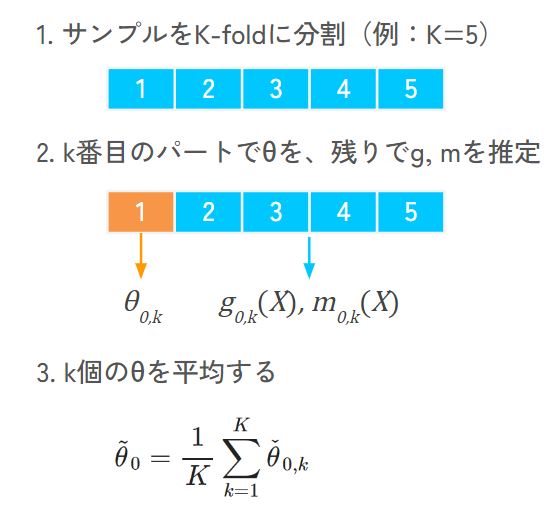

:::{admonition} DML1（簡略版）

1. サンプル $(W_i)^N_{i=1}$ のインデックス $[N]=\{1,\dots,N\}$ のK-foldのランダムな分割 $\left(I_k\right)_{k=1}^K$ を作る。$I_k$のサイズは$n=N/K$である。
2. それぞれの$k\in[K]=\{1,\dots,K\}$について、$I_k^c := \{1,\dots,N\} \backslash I_k$を定義する。
3. 各$k\in[K]$について、局外母数$\eta_0$のML推定量

    $$
    \hat{\eta}_{0, k}=\hat{\eta}_0\left(\left(W_i\right)_{i \in I_k^c}\right)
    $$

    を構築する。

4. 各$k\in[K]$について、推定量$\check{\theta}_{0, k}$を

    $$
    E_{n, k}\left[
    \psi \left(W ; \check{\theta}_{0, k}, \hat{\eta}_{0, k} \right)
    \right]=0
    $$

    の解として構築する。$\psi$はネイマン直交スコアである。

5. 推定量を集計する

    $$
    \widetilde{\theta}_0=\frac{1}{K} \sum_{k=1}^K \check{\theta}_{0, k}
    $$

:::

:::{admonition} DML2（簡略版）

1. サンプル $(W_i)^N_{i=1}$ のインデックス $[N]=\{1,\dots,N\}$ のK-foldのランダムな分割 $\left(I_k\right)_{k=1}^K$ を作る。$I_k$のサイズは$n=N/K$である。
2. それぞれの$k\in[K]=\{1,\dots,K\}$について、$I_k^c := \{1,\dots,N\} \backslash I_k$を定義する。
3. 各$k\in[K]$について、局外母数$\eta_0$のML推定量

    $$
    \hat{\eta}_{0, k}=\hat{\eta}_0\left(\left(W_i\right)_{i \in I_k^c}\right)
    $$

    を構築する。

4. 各$k\in[K]$について、推定量$\tilde{\theta}_0$を

    $$
    \frac{1}{K} \sum_{k=1}^K E_{n, k}\left[\psi\left(W ; \tilde{\theta}_0, \hat{\eta}_{0, k}\right)\right]=0
    $$

    の解として構築する。$\psi$はネイマン直交スコアである。

:::



> We show that if the population risk satisfies a condition called Neyman orthogonality, the impact of the nuisance estimation error on the excess risk bound achieved by the meta-algorithm is of second order.
> 
> [Foster, D. J., & Syrgkanis, V. (2023). Orthogonal statistical learning. The Annals of Statistics, 51(3), 879-908.](https://arxiv.org/pdf/1901.09036.pdf)

## Donsker条件

Robinson (1988）などのセミパラメトリックモデルでも$\sqrt{n}$-consistentで漸近正規性をもつ推定量が作れていた

しかし、Donsker条件（Donsker condition）という条件を満たすクラスの関数（複雑性の低い関数）でなければ、漸近正規性をもたない（[Andrew 1994](https://www.jstor.org/stable/2951475)）

機械学習モデルの収束レートが遅い（Donsker条件）→Cross Fitting


[XユーザーのMasahiro Katoさん: 「Double/debiased machine learningはどういう手法かというと，機械学習はDonsker条件を満たさないので，サンプルを分割することによって，異なる部分集合間で独立だと思えるような局外母数の推定量を構築することで，収束率だけで漸近正規性を出す手法です．」 / X](https://twitter.com/masakat0/status/1314897112316870657)

### プラグイン推定量

モデルのパラメータをモーメント推定する際に、未知の関数をノンパラ推定量で置換してモーメント推定する推定量。
部分線形モデルを含む多くのセミパラメトリック推定量はプラグイン推定量に含まれる。

関心のあるパラメータを$\theta$、局外母数を$\eta$とし、セミパラメトリックモデルが確率変数を$W$として真のパラメータ$(\theta_0, \eta_0)$のもとでモーメント条件

$$
E[m(W, \theta_0, \eta_0)]=0
$$

を満たすとする（$m$は既知の関数）。
第1段階で局外母数$\eta_0$の一致推定量$\hat\eta$を得て、第2段階で標本モーメント条件

$$
\frac{1}{n}\sum^n_{i=1} m(W_i, \hat\beta, \hat\eta)=0
$$

を満たすように$\hat\theta$を推定する。


### プラグイン推定量の漸近正規性

プラグイン推定量が漸近正規性をもつためには、次の2つの条件が鍵となる

1. $\nu_n(\hat\eta) - \nu(\eta_0) \overset{p}{\to} 0$
2. $\sqrt{n}E[m(X_i, \theta_0, \hat\eta)] = o_p(1)$

なお$m(\cdot)$はモーメント条件を構成する既知の関数で、$\nu_n$は経験過程（empirical process）とよばれる関数

$$
\nu_n(\eta) = \frac{1}{\sqrt{n}} \sum_{i=1}^n ( m(X_i, \eta) - E[m(X_i, \eta)] )
$$

である。

ノンパラメトリック推定量の漸近理論ではDonsker条件を用いて条件1を示すことが多いようだが、高次元ではDonsker条件は満たされない

対処法のひとつは標本分割（sample splitting）だが、標本分割すると効率性が低下する。Chernozkov et al. (2018)ではCross-fittingにより効率性を落とさずに推定できることを示した

## $g_0(X)$の推定

Robinson-styleのほうは$g_0(X)$ではなく$\ell_0(X) := E[Y|X]$を使ったのでシンプルにFWL定理であり、わかりやすかった。

DMLの$g(X)$はどう推定するのか?

→ 直接推定できないのでちょっと手順を踏む

ドキュメントの例だと$y - D \theta$を目的変数にしてfitしてるっぽい

```python
psi_a = -np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), d[i_train] - ml_m.predict(x[i_train, :]))
psi_b = np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), y[i_train] - ml_l.predict(x[i_train, :]))
theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)
ml_g.fit(x[i_train, :], y[i_train] - theta_initial * d[i_train])
```

> Remark that the estimator is not able to estimate $\hat{g}_0(X)$ directly, but has to be based on a preliminary estimate of $\hat{m}_0(X)$
>
> [Python: Basics of Double Machine Learning — DoubleML documentation](https://docs.doubleml.org/stable/examples/py_double_ml_basics.html)


:::{admonition} Robinsonのスコア

Robinson (1988)のスコア関数もNeiman orthogonalityを満たし、推定量は残差回帰のような形になるので理解しやすい

$$
E[D|X] \approx \hat{m}_0(X_i)\\
E[Y|X] \approx \hat{\ell}_0(X_i)
$$

を機械学習アルゴリズムで構築し、

$$
\hat{V}_i := D_i - \hat{m}_0(X_i)\\
\tilde{Y}_i := Y_i - \hat{\ell}_0(X_i)
$$

という残差で切片なしの単回帰

$$
\check{\theta}_0
= \left(\frac{1}{n} \sum_{i \in I} \hat{V}_i^2\right)^{-1}
\frac{1}{n} \sum_{i \in I} \hat{V}_i \tilde{Y}_i
$$

を行うというもの。


```python
# 実装のイメージ（簡単のためサンプル分割なし）
from lightgbm import LGBMRegressor

m = LGBMRegressor(max_depth=4, verbose=-1)
m.fit(X, D)
l = LGBMRegressor(max_depth=4, verbose=-1)
l.fit(X, Y)

V_hat = D - m.predict(X)
Y_res = Y - l.predict(X)

theta_hat = np.mean(V_hat * V_hat) ** (-1) * np.mean(V_hat * Y_res)
```


```python
# 実装のイメージ（Cross-fitting）
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)
thetas = []
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    # 局外関数の推定
    m = LGBMRegressor(max_depth=4, verbose=-1).fit(X[train_idx], D[train_idx])
    l = LGBMRegressor(max_depth=4, verbose=-1).fit(X[train_idx], Y[train_idx])
    # 残差の計算
    V_hat = D[test_idx] - m.predict(X[test_idx])
    Y_res = Y[test_idx] - l.predict(X[test_idx])
    # θの推定
    theta_hat = np.mean(V_hat * V_hat) ** (-1) * np.mean(V_hat * Y_res)
    thetas.append(theta_hat)
np.mean(thetas)
```

:::

In [ ]:
# 実装のイメージ（簡単のためサンプル分割なし）
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(X)
thetas = []
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    # 局外関数の推定
    m = LGBMRegressor(max_depth=4, verbose=-1).fit(X[train_idx], D[train_idx])
    l = LGBMRegressor(max_depth=4, verbose=-1).fit(X[train_idx], Y[train_idx])
    # 残差の計算
    V_hat = D[test_idx] - m.predict(X[test_idx])
    Y_res = Y[test_idx] - l.predict(X[test_idx])
    # θの推定
    theta_hat = np.mean(V_hat * V_hat) ** (-1) * np.mean(V_hat * Y_res)
    thetas.append(theta_hat)
np.mean(thetas)

## 参考

- 解説記事: [機械学習×計量経済学：Double/Debiased Machine Learning | Web日本評論](https://www.web-nippyo.jp/13331/)
- [[勉強会資料メモ] Double/Debiased ML - Speaker Deck](https://speakerdeck.com/masa_asa/debiased-ml?slide=32)
- [22 - Debiased/Orthogonal Machine Learning — Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html)
- [CausalML Book](https://causalml-book.org/)の[Chapter 13](https://causalml-book.org/assets/chapters/CausalML_chap_13.pdf)


### DMLによるDID

[Double/debiased machine learning for difference-in-differences models | The Econometrics Journal | Oxford Academic](https://academic.oup.com/ectj/article/23/2/177/5722119)

- 解説: [DMLによる差分の差推定 - Speaker Deck](https://speakerdeck.com/masakat0/dmlniyoruchai-fen-falsechai-tui-ding)
- 関連: [Double-Debiased-Machine-learning-estimator-for-Difference-in-Difference-with-Multiple-Periods.pdf](https://www.researchgate.net/profile/Di-Liu-124/publication/370440876_DoubleDebiased_Machine-learning_estimator_for_Difference-in-Difference_with_Multiple_Periods/links/645015ce5762c95ac3676c6e/Double-Debiased-Machine-learning-estimator-for-Difference-in-Difference-with-Multiple-Periods.pdf)

### 講義動画（Youtube）

[Double Machine Learning for Causal and Treatment Effects - YouTube](https://www.youtube.com/watch?v=eHOjmyoPCFU&list=PLru50RuxzKFAsi9x3La3pidYURmi17ci6&index=4&t=479s)

- MLでのcausal parametersの推定は良いとは限らない
- double or orthogonalized MLとsample splittingによって、causal parametersの高精度な推定が可能

Partially Linear Modelを使う

$$
Y = D \theta_0 + g_0(Z) + U
, \hspace{1em} E[U|Z, D] = 0
$$

- MLをそのまま使うと一致推定量にならない（例えば$Y - D$で$g_0(Z)$をRandom Forestで学習しても、予測精度は良いがバイアスがある）
- FWL定理を用いて、残差の回帰にするとよい

$$
\hat{W} = Y - \hat{E[Y|Z]}\\
\hat{V} = D - \hat{E[D|Z]}
$$


モーメント条件

1. Regression adjustment: $E[(Y - D \theta_0 - g_0(Z) ) D] = 0$
2. "propensity score adjustment": $E[(Y - D \theta_0) (D - E[D|Z])] = 0$
3. Neyman-orthogonal (semi-parametrically efficient under homoscedasticity): $E[(\hat{W} - \hat{V}\theta_0) \hat{V}] = E[\{(Y - E[Y|Z]) - (D - E[D|Z])\theta_0\} (D - E[D|Z])] = 0$

3は不偏


Sample Splitting


Splittingによるefficiencyの低下問題

- 2個に分けて2回やって平均とればfull efficiency → k個に分けての分析をk回やって平均とってもfull efficiency



## 応用研究

[[2002.08536] Debiased Off-Policy Evaluation for Recommendation Systems](https://arxiv.org/abs/2002.08536)
- PR: [AI Lab、推薦システム分野におけるトップカンファレンス「RecSys2021」にて共著論文採択 ー高次元なデータを使った意思決定評価の信頼性を改善ー | 株式会社サイバーエージェント](https://www.cyberagent.co.jp/news/detail/id=26585)

## 関連研究

[[2305.04174] Root-n consistent semiparametric learning with high-dimensional nuisance functions under minimal sparsity](https://arxiv.org/abs/2305.04174)

- 先行研究まとめがある

[[2008.06461] Estimating Structural Target Functions using Machine Learning and Influence Functions](https://arxiv.org/abs/2008.06461)

- Influence Function Learningという新しいフレームワークを提案

[Library Flow Chart — econml 0.15.0 documentation](https://econml.azurewebsites.net/spec/flowchart.html)
- 派生モデルの使い分けについて

## 部分線形モデルに対するモーメント条件

異なる推定量でどれだけバイアスが入るか確認したい

In [4]:
import numpy as np

def g(X):
    # linear
    return 2 * X

n = 1000
np.random.seed(0)
X = np.random.uniform(size=n)
theta = 3
D = X + np.random.normal(size=n)
Y = D * theta + g(X) + np.random.normal(size=n)

import pandas as pd
df = pd.DataFrame({"Y": Y, "D": D, "X": X})
X_mat = X.reshape(-1, 1)
D_mat = D.reshape(-1, 1)

ナイーブな推定量

$$
E[UD] = E[(Y  - D\theta - g(X)) D] = 0
$$

$$
\hat{\theta}_0=\left(\frac{1}{n} \sum_{i \in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i \in I} D_i\left(Y_i-\hat{g}_0\left(X_i\right)\right)
$$

かりに、$\hat{g}(X_i)$は$Y_i$を$X$に回帰する（予測値$\hat{Y}_i = \hat{g}(X_i)$を作る）とするなら

In [5]:
from lightgbm import LGBMRegressor

# Y ~ X
g = LGBMRegressor(max_depth=4, verbose=-1)
g.fit(X_mat, Y)

# Y_res := Y - g(X)
Y_res = Y - g.predict(X_mat)
theta_hat = np.mean(D**2) ** (-1) * np.mean(D * Y_res)
print(f"θ={theta_hat:.3f}")

# Y_res ~ D のOLS
import statsmodels.formula.api as smf
final_model = smf.ols(
    formula='Y_res ~ -1 + D',
    data=df.assign(
        Y_res = Y - g.predict(X_mat)
    )
).fit()
final_model.summary().tables[1]

θ=1.981


,coef,std err,t,P>|t|,[0.025,0.975]
D,1.9811,0.049,40.446,0.000,1.885,2.077


In [6]:
from sklearn.linear_model import LinearRegression

# gをDonsker条件を満たしそうな線形モデルにしたらどうなるか
# これは普通に残渣回帰でもないしだめか
# Y ~ X
g = LinearRegression()
g.fit(X_mat, Y)

# Y_res := Y - g(X)
Y_res = Y - g.predict(X_mat)
theta_hat = np.mean(D**2) ** (-1) * np.mean(D * Y_res)
print(f"θ={theta_hat:.3f}")

θ=2.177


In [7]:
g.coef_

array([4.65807719])

In [8]:
# TODO: モーメント条件の方向微分をplotできないものか？
# 横軸はthetaとr

:::{card} 疑問：$\hat{g}(X)$はどう得る？

$Y = g(X)$で学習させる？でもそうなると$E[Y|X] = \ell(X)$を使うRobinsonとの違いは…？

:::

### DML score function


ネイマン直交性を満たす

$$
E[UV] = E[ \{Y-D \theta-g(X)\}(D-m(X)) ]=0
$$

$\hat{V}= D-\hat{m}_0(X)$

$$
\check{\theta}_0=\left(\frac{1}{n} \sum_{i \in I} \widehat{V}_i D_i\right)^{-1} \frac{1}{n} \sum_{i \in I} \widehat{V}_i\left(Y_i-\hat{g}_0\left(X_i\right)\right)
$$



In [9]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

# Y ~ X
g = LGBMRegressor(max_depth=4, verbose=-1)
g.fit(X_mat, Y)

# D ~ X
m = LGBMRegressor(max_depth=4, verbose=-1)
m.fit(X_mat, D)

# y_res := Y - g(X)
# V_hat := D - m(X)
V_hat = D - m.predict(X_mat)
Y_res = Y - g.predict(X_mat)

theta_hat = np.mean(V_hat * D) ** (-1) * np.mean(V_hat * Y_res)
print(f"θ={theta_hat:.3f}")

import statsmodels.formula.api as smf
final_model = smf.ols(
    formula='Y_res ~ -1 + V_hat',
    data=df.assign(
        Y_res = Y_res,
        V_hat = V_hat,
    )
).fit()
final_model.summary().tables[1]

θ=2.872


,coef,std err,t,P>|t|,[0.025,0.975]
V_hat,2.9672,0.032,93.561,0.000,2.905,3.029


### Robinson-style "partialling-out" score function

:::{card} Robinson (1988)の推定量

部分線形モデル

$$
Y = D \theta_0 + g(X) + U
, \quad E[U|D,X]=0
$$

の両辺を$X$で条件づけて期待値をとると

$$
E[Y|X] = E[D|X] \theta_0 + g(X)
$$

これをモデルから差し引くと

$$
Y - E[Y|X]
= \theta_0 (D - E[D|X]) + U
$$

という線形回帰の形になる。

ただし、$E[Y|X], E[D|X]$は未知なのでそれぞれノンパラメトリック推定量$\hat{\ell}(X), \hat{m}(X)$で置き換える。
:::


こちらもネイマン直交性を満たす。

$$
\mathrm{E}\left[\left\{(Y-E[Y \mid X])-(D-E[D \mid X]) \theta_0\right\}(D-E[D \mid X])\right]=0
$$

$V=D - E[D|X] = D-m_0(X)$として、$\ell_0(X) := E[Y|X]$とすると

$$
\mathrm{E}\left[\left((Y-\ell_0(X))-V \theta_0\right)V\right]=0
$$

[DMLの論文のSection 4.1](https://academic.oup.com/ectj/article/21/1/C1/5056401#130274171)でRobinsonのスコア関数もネイマン直交性を満たすことを述べているが、DMLのスコア関数が優れてるなどといった説明はとくに無いようだった。

:::{margin}

FWL的にしてCrossFittingするという、[Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html)の方法はRobinson-styleのscore functionと思われる。

Donsker条件を満たさないであろうLightGBMでもバイアスが入らないのはCrossFittingがそれだけバイアスを抑えているということだろうか。
:::

### cross fitting

In [10]:
# cross-fittingあり
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

m = LGBMRegressor(max_depth=6, verbose=-1)
df["V_hat"] = df["D"] - cross_val_predict(m, df[["X"]], df["D"], cv=5)

g = LGBMRegressor(max_depth=6, verbose=-1)
df["Y_res"] = df["Y"] - cross_val_predict(g, df[["X"]], df["Y"], cv=5)

import statsmodels.formula.api as smf
final_model = smf.ols(formula='Y_res ~ -1 + V_hat', data=df).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
V_hat,2.9471,0.032,92.429,0.000,2.885,3.010


## 参考

- [機械学習×計量経済学：Double/Debiased Machine Learning | Web日本評論](https://www.web-nippyo.jp/13331/)
- [金本拓. (2024). 因果推論: 基礎から機械学習・時系列解析・因果探索を用いた意思決定のアプローチ. 株式会社 オーム社.](https://amzn.to/4cCXO9X)

ノンパラ関連
- [末石直也. (2024). データ駆動型回帰分析: 計量経済学と機械学習の融合.](https://amzn.to/3yITuIz)
- [西山慶彦, & 人見光太郎. (2023). ノン・セミパラメトリック統計解析.](https://amzn.to/3Mj6qrt)

モーメント法
- [西山慶彦, 新谷元嗣, 川口大司, & 奥井亮. (2019). 計量計済学.](https://amzn.to/3T5k4SZ)
